In [1]:
#IMPORT DELLE LIBRERIE
import numpy as np 
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt

import skimage.transform as trans
from skimage import io, color
from skimage.util import random_noise

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
#DOWNLOAD DEL DATASET
lfw_dataset=fetch_lfw_people(resize=0.256,download_if_missing=True,slice_=None,color=True)
print(lfw_dataset.images.shape)
X=lfw_dataset.images
y=lfw_dataset.target


#SPLIT DEL DATASET PER IL TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2)

#SPLIT DEL DATASET PER IL VALIDATION SET
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.1)

#MODIFICA DI COME VENGONO SALVATE LE IMMAGINI IN MEMORIA
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

(13233, 64, 64, 3)


In [3]:
#DIMENSIONI DEL TRAINING SET
X_train.shape

(9527, 64, 64, 3)

In [4]:
#DIMENSIONI DEL TEST SET
X_test.shape

(2647, 64, 64, 3)

In [5]:
#DIMENSIONI DEL VALIDATION SET
X_val.shape

(1059, 64, 64, 3)

In [6]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI
noise_factor = 0.2

X_train_noisy = random_noise(X_train, mode="s&p",clip=True, amount=noise_factor)
X_test_noisy = random_noise(X_test, mode="s&p",clip=True, amount=noise_factor)
X_val_noisy = random_noise(X_val, mode="s&p",clip=True, amount=noise_factor)

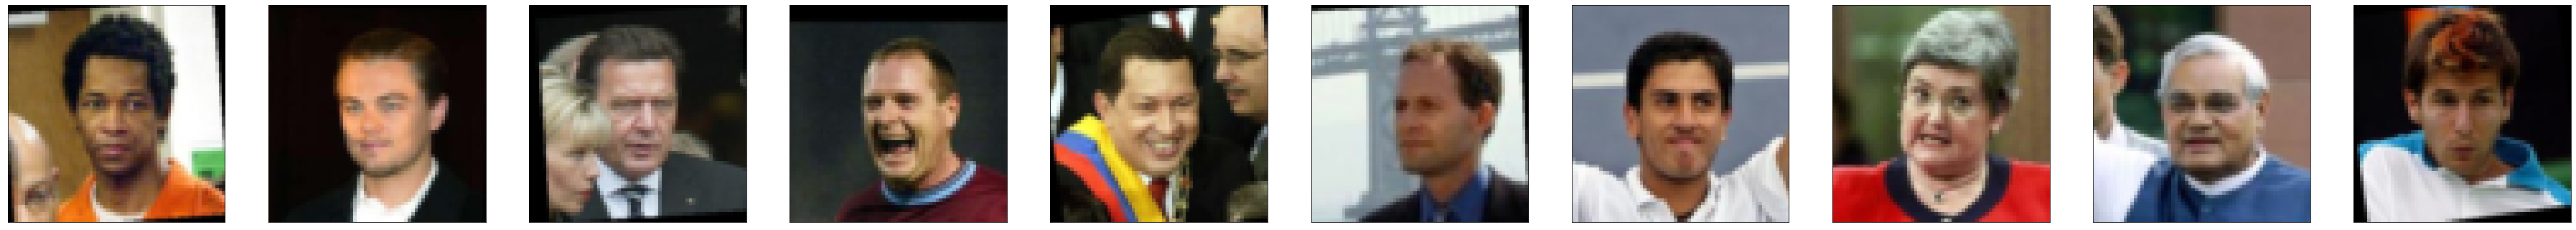

In [7]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

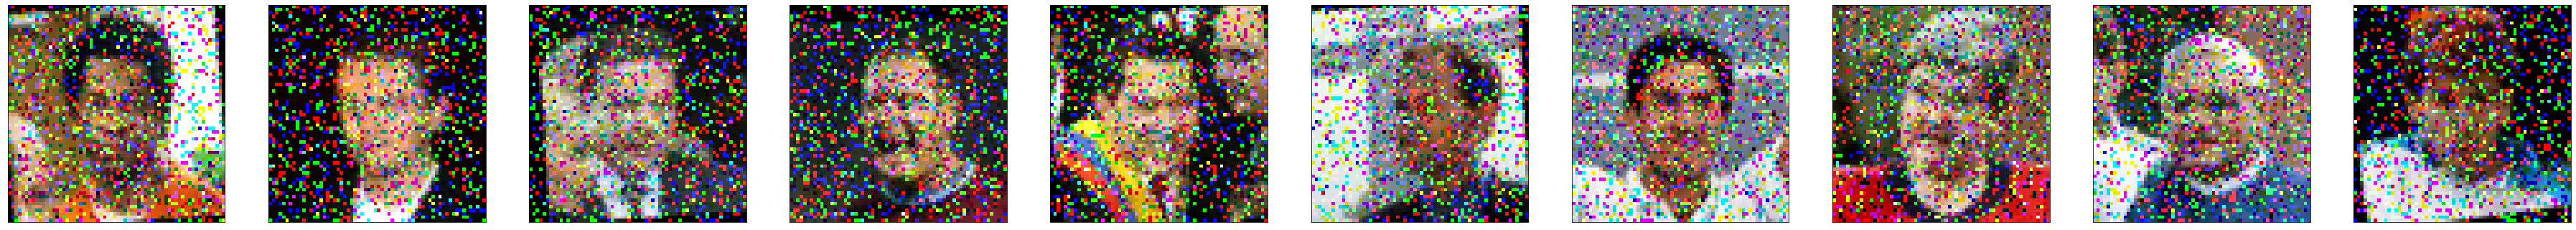

In [8]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET COL RUMORE
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train_noisy[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
#MODELLO U-NET
input_size = X_train.shape[1:]
inputs = Input(input_size)
conv1 = Conv2D(64,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D((2,2))(conv1) 
conv2 = Conv2D(128,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D((2,2))(conv2)
conv3 = Conv2D(256,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D((2,2))(conv3)   
conv4 = Conv2D(512,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D((2,2))(drop4)

conv5 = Conv2D(1024,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([up6, drop4], axis = 3)
conv6 = Conv2D(512,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)
    
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([up7, conv3], axis = 3)
conv7 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)
    
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([up8, conv2], axis = 3)
conv8 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)
    
up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([up9, conv1], axis = 3)
conv9 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv9)

conv10 = Conv2D(3, (1,1), padding='same', activation='sigmoid')(conv9)

model = Model(inputs, conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [11]:
#TRAINING DEL MODELLO
history = model.fit(X_train_noisy, X_train, epochs=100, batch_size=16, validation_data=(X_val_noisy,X_val))

Epoch 1/100
596/596 [==============================] - 80s 113ms/step - loss: 0.0087 - val_loss: 0.0059
Epoch 2/100
596/596 [==============================] - 62s 104ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 3/100
596/596 [==============================] - 62s 104ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 4/100
596/596 [==============================] - 63s 106ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 5/100
596/596 [==============================] - 62s 104ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 6/100
596/596 [==============================] - 62s 104ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 7/100
596/596 [==============================] - 62s 104ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/100
596/596 [==============================] - 63s 105ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 9/100
596/596 [==============================] - 62s 104ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/100
596/596 [==============================] - 62s 104m

In [12]:
#TEST DEL MODELLO SUL TEST SET
predict = model.predict(X_test_noisy)

83/83 [==============================] - 7s 58ms/step


In [13]:
predict.shape

(2647, 64, 64, 3)

In [14]:
n=10

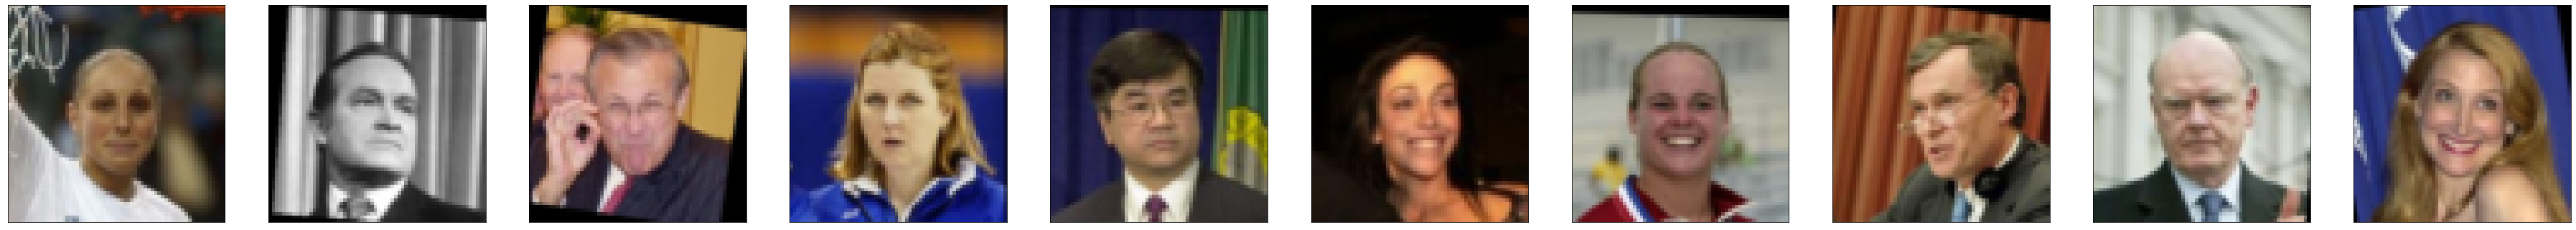

In [15]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

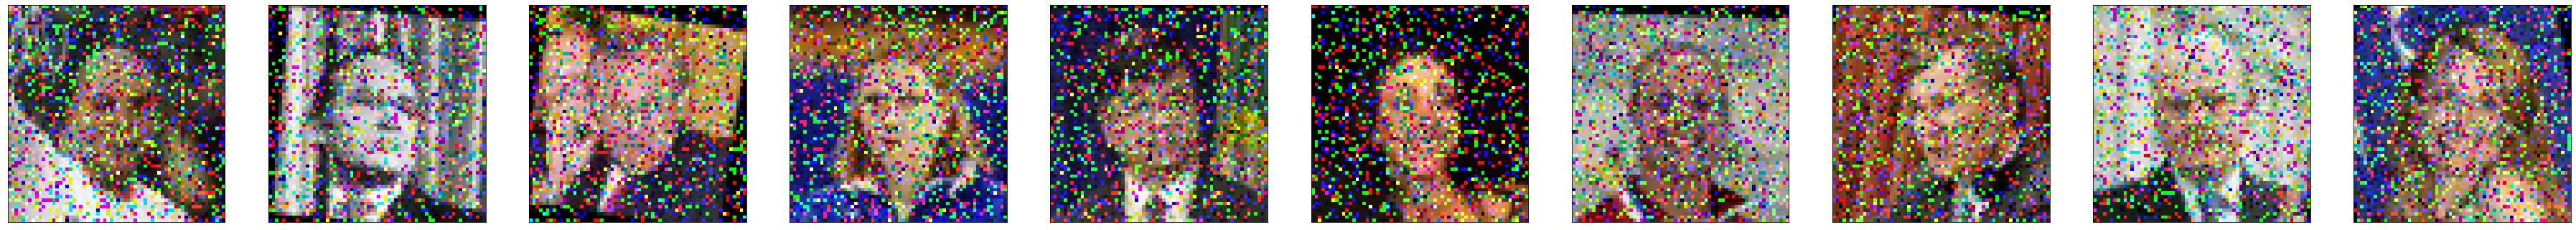

In [16]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET COL RUMORE
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

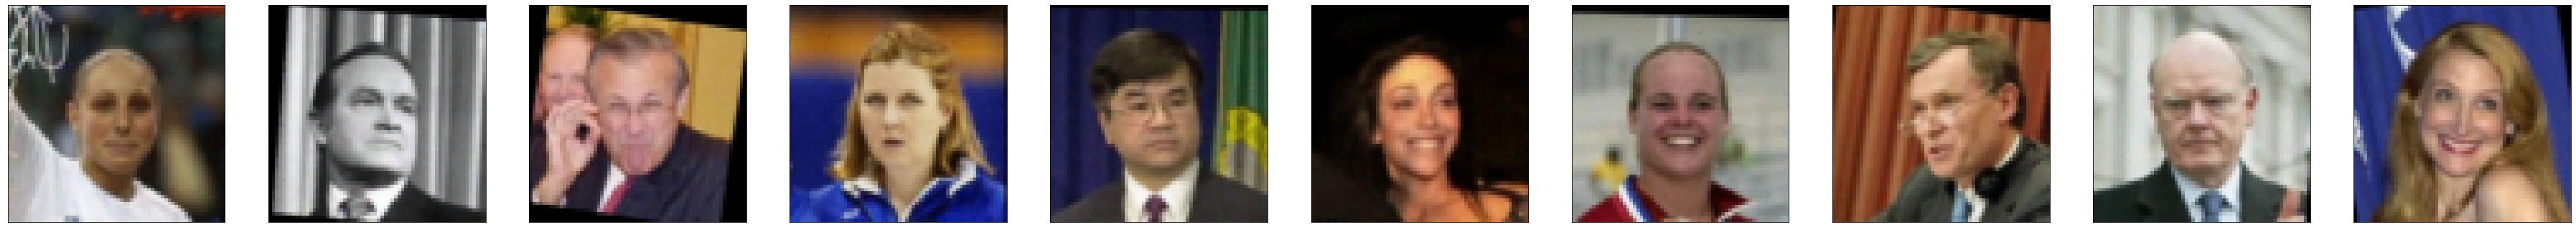

In [17]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET SENZA RUMORE (OUTPUT DELLA UNET)
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
NUMBER_OF_TEST_IMAGES = len(X_test)

mse = mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
mae = mean_absolute_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
rmse = np.sqrt(mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3)))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.000107444845
Mean Absolute Error: 0.0064008273
Root Mean Squared Error: 0.010365561


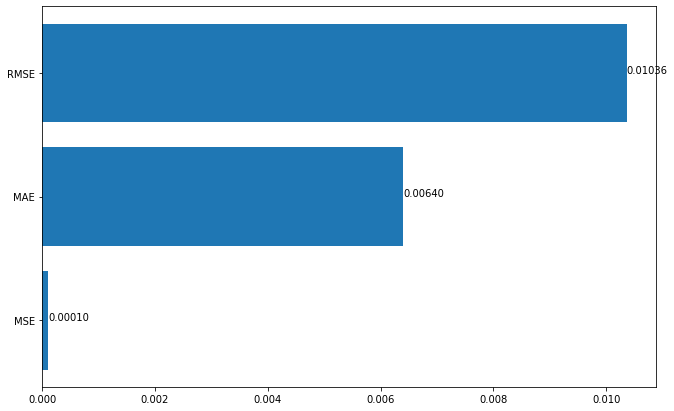

In [19]:
plt.figure(figsize = (11,7))
x = ["MSE","MAE","RMSE"]
y = [mse,mae,rmse]
plt.barh(x, y)
  
for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:7])
plt.show()